# Tool Calling LLM

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lalanikarim/tool_calling_llm/blob/main/ToolCallingLLM-Tutorial.ipynb)

Tool Calling LLM is a python mixin that lets you add tool calling capabilities effortlessly to [LangChain](https://langchain.com)'s Chat Models that don't yet support tool/function calling natively. Simply create a new chat model class with ToolCallingLLM and your favorite chat model to get started.

With ToolCallingLLM you also get access to the following functions:
1. `.bind_tools()` allows you to bind tool definitions with a llm.
2. `.with_structured_output()` allows you to return structured data from your model. This is now provided by LangChain's `BaseChatModel` class.

At this time, ToolCallingLLM has been tested to work with ChatOllama, ChatNVIDIA, and ChatLiteLLM with Ollama provider.

The [OllamaFunctions](https://python.langchain.com/v0.2/docs/integrations/chat/ollama_functions/) was the original inspiration for this effort. The code for ToolCallingLLM was abstracted out of `OllamaFunctions` to allow it to be reused with other non tool calling Chat Models.

Note: This notebook demonstrates how to you might create a Tool Calling LLM from `ChatOllama`. It is important to note that recently, [`ChatOllama`](https://pypi.org/project/langchain-ollama/) was updated with some tool calling support. 
However, only certain types of models seem to be supported. Using `phi3`, for instance, returns an error message stating that the model doesn't support tool calling.

When you create a tool calling llm with `tool_calling_llm` package, you are able to use any model that comes with decent JSON generation support.


## Install Ollama

Visit [ollama.com](https://ollama.com) to download latest version of Ollama.

In [ ]:
##%%capture
#!apt install pciutils

In [19]:
#!curl -fsSL https://ollama.com/install.sh | sh

In [ ]:
##%%bash --bg
#ollama serve &> ollama.log 2>&1

## Download `llama3.1` model

Once Ollama is installed and running locally, run the following command to download the `llama3.1 8b` model.

```bash
ollama pull llama3.1
```

In [20]:
##%%capture
#!ollama pull llama3.1

## Install python packages

In [1]:
%%capture
%pip install -U pip langchain langchain-core langchain-community langchain-ollama \
langgraph duckduckgo-search httpx 

## Using `bind_tools`

### Import modules

In [2]:
from  src.tool_calling_llm import ToolCallingLLM
from langchain_ollama import ChatOllama
from langchain_community.tools import DuckDuckGoSearchRun

### Create Ollama With Tool with ChatOllama

In [4]:
class OllamaWithTools(ToolCallingLLM, ChatOllama):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @property
    def _llm_type(self):
        return "ollama_with_tools"

### Initialize with Llama 3.1 8b LLM in JSON mode

In [9]:
llm = OllamaWithTools(model="llama3.1:8b",format="json",base_url="http://host.docker.internal:11434")


### Testing without tools

In [10]:
llm.invoke("What is the capital of England?")

AIMessage(content='London is the capital of England.', id='run-02c54c40-08a4-4985-8b05-91f0ae1d0ac0-0')

### Binding tools

In [11]:
tools = [DuckDuckGoSearchRun()]
llm_tools = llm.bind_tools(tools=tools)

### Testing with tools

In [12]:
llm_tools.invoke("Who won the silver medal in shooting in the Paris Olympics in 2024?")

AIMessage(content='', id='run-d07a23bd-bf58-4be9-b034-996616e13360-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Paris Olympics 2024 shooting silver medal winner'}, 'id': 'call_0bb43cc18c65430e99e9fcc54c161f57', 'type': 'tool_call'}])

## Using `with_structured_output`

### Import modules

In [13]:
from langchain.pydantic_v1 import BaseModel, Field
from typing import Optional, List

### Define Structured Output Definition with Pydantic

In [14]:
class ContactInfo(BaseModel):
    """
    Contact information of the subject
    """
    name: str = Field(description="Full name of the subject")
    organization: str = Field(description="Employer who the subject works for")
    position: str = Field(description="Subject's position with the employer organization")
    email: str = Field(description="Email address of the subject")
    skills: List[str] = Field(description="Skills the subject has")

### Binding Output Definition to the LLM

In [15]:
llm_with_structured_output = llm.with_structured_output(ContactInfo)

### Testing Structured Output from LLM

In [16]:
llm_with_structured_output.invoke("Karim Lalani is a Content Contributor for Austin LangChain Meetup Group. "
                                  "He can code in Python and enjoys building AI application. "
                                  "His email address is jimmy00784@gmail.com.")

ContactInfo(name='Karim Lalani', organization='Austin LangChain Meetup Group', position='Content Contributor', email='jimmy00784@gmail.com', skills=['Python', 'Building AI applications'])

## Using with LangGraph

### Import modules

In [17]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import START, END, MessageGraph, MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import display, Image

### Prepare tools, LLM, and Tool Node

In [18]:
tools = [DuckDuckGoSearchRun()]
llm_with_tools = llm.bind_tools(tools=tools)
tool_node = ToolNode(tools)

### Function to handle routing

In [19]:
def should_continue(state: MessagesState):
    last_message = state[-1]
    if last_message.tool_calls:
        return "tools"
    else:
        return "end"

### Building LangGraph Agent

In [20]:
builder = MessageGraph()
builder.add_node("oracle_node",llm_with_tools)
builder.add_node("tool_node",tool_node)
builder.add_edge(START, "oracle_node")
builder.add_conditional_edges("oracle_node", should_continue, {"tools":"tool_node","end":END})
builder.add_edge("tool_node","oracle_node")
graph = builder.compile()

### Visualizing Agent Graph

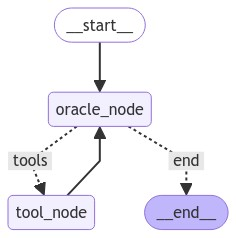

In [21]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Testing LangGraph Agent built with Tool Calling LLM

In [22]:
for msg in graph.stream(HumanMessage("Who won the silver medal in Paris Olympics for sharpshooting in 2024?")):
    print(msg)

{'oracle_node': AIMessage(content='', id='run-48b89127-25d4-4904-ae8c-5c43962f1079-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Paris Olympics 2024 sharpshooting silver medalist'}, 'id': 'call_93ba62d619b94ba880879ee98d4b76ee', 'type': 'tool_call'}])}
{'tool_node': [ToolMessage(content="Turkish sharpshooter Yusuf Dikeç didn't need special lenses or big ear protectors to win the silver medal in the air pistol team event at the 2024 Paris Olympics. Turkish Olympian Yusuf Dikec won silver in the 2024 Paris Olympics mixed air pistol team event. Dikec went viral for his nonchalant approach of not using any high-tech aids in the competition.Aug ... CHATEAUROUX, France (AP) — Turkish pistol shooter Yusuf Dikec has gone viral on social media for his seemingly casual attitude while shooting his way to a silver medal at the 2024 Olympics. The most-shared images show Dikec shooting in a T-shirt with one hand in his pocket, a seemingly standard pair of glasses and an impassive 

ValueError: Failed to parse a response from llama3.1:8b output: {"name": "__conversational_response", "parameters": {"response": "The silver medal winner in sharpshooting at the Paris Olympics was Yusuf Dikec"}}